In [1]:
import pandas as pd
import numpy as np
from scipy.special import expit, logit

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.linear_model import LogisticRegression

In [3]:
import lightgbm as lgb

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import weight_of_evidence

In [25]:
import importlib
importlib.reload(weight_of_evidence)

<module 'weight_of_evidence' from '/Users/olivercairns/Desktop/code/WeightOfEvidenceDemo/weight_of_evidence.py'>

In [26]:
np.random.seed=1234

In [27]:
company_age = np.arange(1,100,0.01)

In [28]:
standard_scaled_age = (company_age - company_age.mean()) / company_age.std()

In [29]:
linear_risk = expit(standard_scaled_age)

In [30]:
non_linear_risk = expit(standard_scaled_age**5)

In [31]:
def simulate_outcome(risk_vector):
    random_draws = np.random.uniform(size=risk_vector.shape)
    return (risk_vector > random_draws).astype(int)

In [32]:
def non_mono_fn(company_age):
    if company_age <= 25:
        return 0.25
    elif company_age <= 75:
        return 0.75
    else:
        return 0.25

In [33]:
non_mono_vec = np.vectorize(non_mono_fn)

In [34]:
non_mono_risk = non_mono_vec(company_age)

In [35]:
SCENARIOS = [(linear_risk, 'linear'),
    (non_linear_risk, 'non-linear'),
                      (non_mono_risk, 'non-monotonic')]

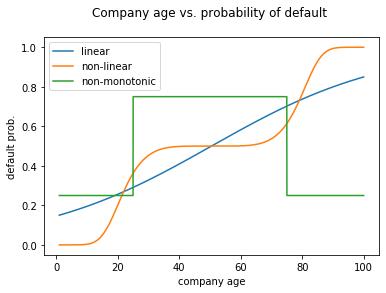

In [36]:
plt.plot(company_age,linear_risk)
plt.plot(company_age,non_linear_risk)
plt.plot(company_age,non_mono_risk)
plt.legend(['linear','non-linear','non-monotonic'])
plt.title('Company age vs. probability of default \n')
plt.xlabel('company age')
plt.ylabel('default prob.')

plt.show()

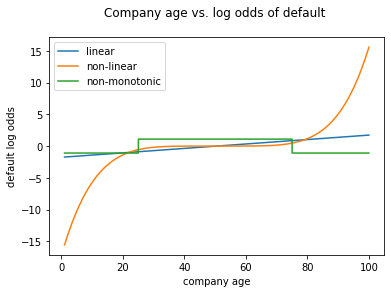

In [37]:
plt.plot(company_age,logit(linear_risk))
plt.plot(company_age,logit(non_linear_risk))
plt.plot(company_age,logit(non_mono_risk))
plt.legend(['linear','non-linear','non-monotonic'])
plt.title('Company age vs. log odds of default \n')
plt.xlabel('company age')
plt.ylabel('default log odds')

plt.show()

In [38]:
MODELS = (
  ('lightgbm',  lgb.LGBMClassifier()),
('log reg',LogisticRegression(solver='lbfgs')))

In [39]:
results = {'scenario':[],'roc_auc':[],'brier':[],'model':[]}
for risk_vector, scenario_name in SCENARIOS:
    for model_name, classifier in MODELS: 
        for _ in range(10):
            y_train = simulate_outcome(risk_vector)
            y_test  = simulate_outcome(risk_vector)
            X = np.array([company_age]).T
            classifier.fit(X,y_train)
            y_pred = classifier.predict_proba(X)[:,1]
            roc_auc = roc_auc_score(y_test,y_pred)
            brier = brier_score_loss(y_test,y_pred)

            results['scenario'].append(scenario_name)
            results['roc_auc'].append(roc_auc)
            results['brier'].append(brier)
            
            results['model'].append(model_name)
        

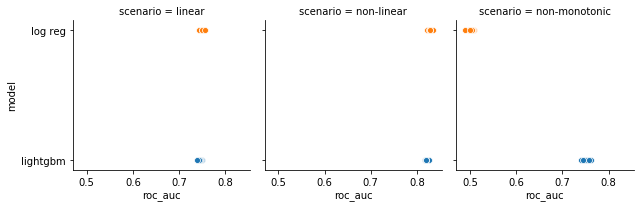

In [40]:
g = sns.FacetGrid(data=pd.DataFrame(results),col='scenario',hue='model')
g.map(sns.scatterplot,'roc_auc','model')

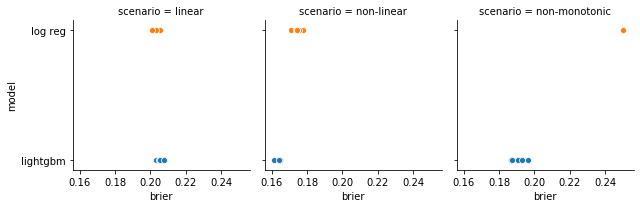

In [41]:
g = sns.FacetGrid(data=pd.DataFrame(results),col='scenario',hue='model')
g.map(sns.scatterplot,'brier','model')

In [42]:
tree_binner = weight_of_evidence.TreeBinner(max_depth=2)

In [43]:
y_train = simulate_outcome(non_mono_risk)
y_test  = simulate_outcome(non_mono_risk)


In [44]:
X = pd.DataFrame(data=X, columns=['company_age'])

In [45]:
y_train = pd.Series(y_train)

In [46]:
X_binned= tree_binner.fit_transform(X,y_train)

In [48]:
tree_binner.single_var_decision_tree.tree_

In [49]:
X_binned.company_age.unique()

array(['(-inf, 24.99]', '(24.99, 98.76]', '(98.76, inf]'], dtype=object)

In [50]:
woe_scaler = weight_of_evidence.WoeScaler()

In [51]:
X_woe = woe_scaler.fit_transform(X_binned,y_train)

In [52]:
woe_scaler.woe_values_

{'company_age': {'(-inf, 24.99]': -1.0963912994153253,
  '(24.99, 98.76]': 0.3385640444728679,
  '(98.76, inf]': -0.7672551527136671}}

In [53]:
ss = StandardScaler()

In [54]:
X_ss = ss.fit_transform(X_woe)

Text(0.5, 1.0, 'Distribution of values - Woe binned & standard scaled \n')

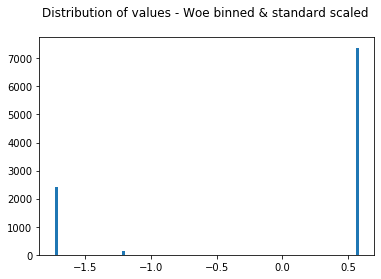

In [55]:
ax = plt.hist(X_ss,bins=100)
plt.title('Distribution of values - Woe binned & standard scaled \n')

In [56]:
woebin_logit = Pipeline(
        steps=[
            ("tree_bin", weight_of_evidence.TreeBinner(max_depth=3)),
            ("woe_scale", weight_of_evidence.WoeScaler()),
            ("standard_scale", StandardScaler()),
            ('log_reg_classifier',LogisticRegression(solver='lbfgs') ),
        ]
    )

In [57]:
for risk_vector, scenario_name in SCENARIOS:
    for _ in range(10):
        y_train = pd.Series(simulate_outcome(risk_vector))
        y_test  = simulate_outcome(risk_vector)
        X = np.array([company_age]).T
        X = pd.DataFrame(data=X, columns=['company_age'])
        
        woebin_logit.fit(X,y_train)
        y_pred = woebin_logit.predict_proba(X)[:,1]
        auc = roc_auc_score(y_test,y_pred)
        brier = brier_score_loss(y_test,y_pred)

        results['scenario'].append(scenario_name)
        results['roc_auc'].append(auc)
        results['brier'].append(brier)

        results['model'].append('woebinned log reg')

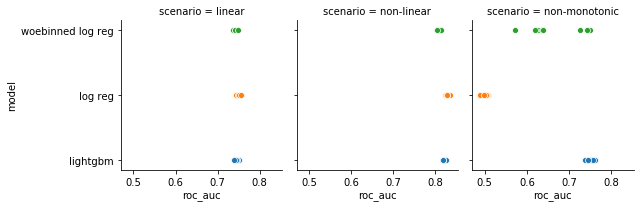

In [58]:
g = sns.FacetGrid(data=pd.DataFrame(results),col='scenario',hue='model')
g.map(sns.scatterplot,'roc_auc','model')

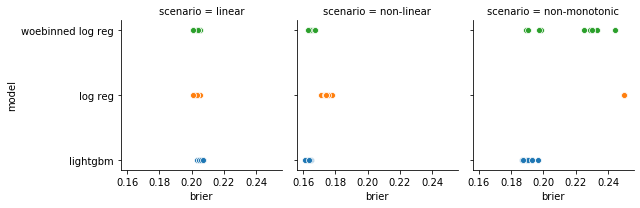

In [59]:
g = sns.FacetGrid(data=pd.DataFrame(results),col='scenario',hue='model')
g.map(sns.scatterplot,'brier','model')

In [60]:
pd.DataFrame(results).groupby(['scenario','model'])[['brier']].mean()

brier
scenario      model                      
linear        lightgbm           0.205599
              log reg            0.202575
              woebinned log reg  0.203595
non-linear    lightgbm           0.163529
              log reg            0.174666
              woebinned log reg  0.164859
non-monotonic lightgbm           0.190356
              log reg            0.250006
              woebinned log reg  0.216753